In [1]:
%load_ext autoreload
%autoreload 2

from scipy import signal
import numpy as np
from scipy.fftpack import fft, ifft
import pandas as pd

import matplotlib
matplotlib.use('nbagg')
from pylab import rcParams
rcParams['figure.figsize'] = 9, 4
import matplotlib.pyplot as plt
import scipy


from pyha import Hardware, simulate, sims_close, Complex, resize, hardware_sims_equal
from pyha.common.util import *
from pyha.common.float import *

# FIR tests

In [2]:
class FIRFloat(Hardware):
    def __init__(self, taps):
        self.DELAY = 2

        self.TAPS = [Float(x) for x in np.array(taps).tolist()]
#         self.TAPS = np.array(taps).tolist()
        self.TAPS_ORIG = taps

        # registers
        self.acc = [Float()] * len(taps)
        self.mul = [Float()] * len(taps)
        # self.out = Float()

    def main(self, x):
        """ Transposed FIR structure """
        self.acc[0] = x * self.TAPS[-1]
        for i in range(1, len(self.acc)):
            self.mul[i] = x * self.TAPS[len(self.TAPS) - 1 - i]
            self.acc[i] = self.acc[i - 1] + self.mul[i]

        return self.acc[-1]

    def model_main(self, x):
        return signal.lfilter(self.TAPS_ORIG, [1.0], x)

In [3]:
np.random.seed(0)
taps = signal.remez(128, [0, 0.1, 0.155, 0.5], [1, 0])
# taps = signal.remez(511, [0, 0.4/2, 0.43/2, 1.0/2], [1, 0])
# taps = np.random.uniform(-1, 1, 256)
inp = np.random.uniform(-1, 1, 1024) * 8 * 8 * 16 * 3
# inp = np.random.normal(scale=32, size=1024)

<IPython.core.display.Javascript object>


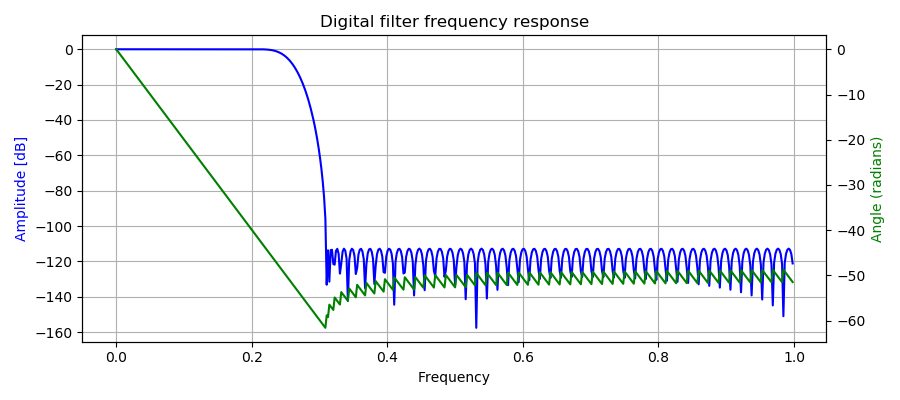

<IPython.core.display.Javascript object>


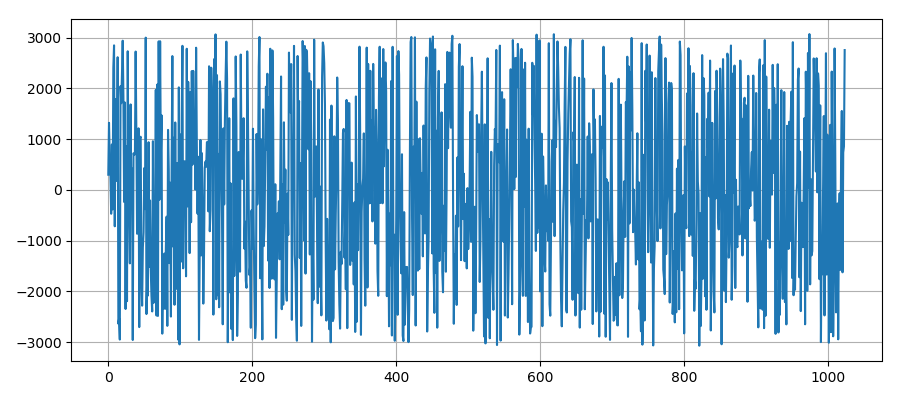

In [4]:
def show_freqz(taps):
    w, h = scipy.signal.freqz(taps)
    fig, ax1 = plt.subplots(1, 1)
    plt.title('Digital filter frequency response')
    ax1.plot(w / np.pi, 20 * np.log10(abs(h)), 'b')
    ax1.set_ylabel('Amplitude [dB]', color='b')
    ax1.set_xlabel('Frequency')
    plt.grid()
    ax2 = ax1.twinx()
    angles = np.unwrap(np.angle(h))
    ax2.plot(w / np.pi, angles, 'g')
    ax2.set_ylabel('Angle (radians)', color='g')
    ax2.axis('tight')
    plt.tight_layout()
    plt.show()
    
show_freqz(taps)

plt.plot(inp)
show_plot()

In [5]:
results = {}

with force_format(radix=32, exponent_bits=3, fractional_bits=14):
    dut = FIRFloat(taps)
    sims = simulate(dut, inp, input_types=[Float()], simulations=['MODEL', 'PYHA'])
    results['Float64'] = np.array([float(x) for x in sims['MODEL']])
    results['Radix32'] = np.array([float(x) for x in sims['PYHA']])
#     results['RTL'] = np.array([float(x) for x in sims['RTL']])

with force_format(radix=4, exponent_bits=5, fractional_bits=12):
    dut = FIRFloat(taps)
    sims = simulate(dut, inp, input_types=[Float()], simulations=['PYHA'])
    results['Radix16'] = np.array([float(x) for x in sims['PYHA']])

with force_format(float16_mode=True):
    dut = FIRFloat(taps)
    sims = simulate(dut, inp, input_types=[Float()], simulations=['PYHA'])
    results['Float16'] = np.array([float(x) for x in sims['PYHA']])

INFO:sim:Converting model to hardware types ...
INFO:sim:Running "MODEL" simulation...
INFO:sim:OK!
INFO:sim:Converting simulation inputs to hardware types...
INFO:sim:Running "PYHA" simulation...


100%|██████████| 1026/1026 [00:02<00:00, 403.03it/s]

INFO:sim:OK!
INFO:sim:Simulations completed!
INFO:sim:Converting model to hardware types ...
INFO:sim:Converting simulation inputs to hardware types...
INFO:sim:Running "PYHA" simulation...



100%|██████████| 1026/1026 [00:02<00:00, 413.38it/s]

INFO:sim:OK!
INFO:sim:Simulations completed!
INFO:sim:Converting model to hardware types ...
INFO:sim:Converting simulation inputs to hardware types...
INFO:sim:Running "PYHA" simulation...



100%|██████████| 1026/1026 [00:00<00:00, 1512.88it/s]

INFO:sim:OK!
INFO:sim:Simulations completed!


<IPython.core.display.Javascript object>


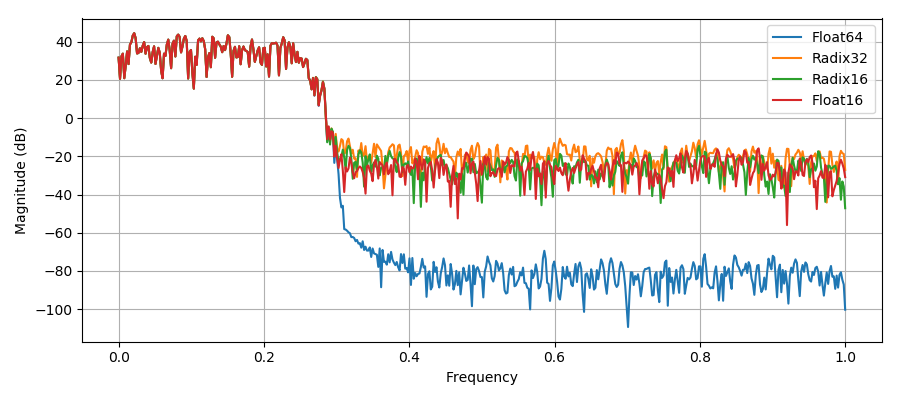

<IPython.core.display.Javascript object>


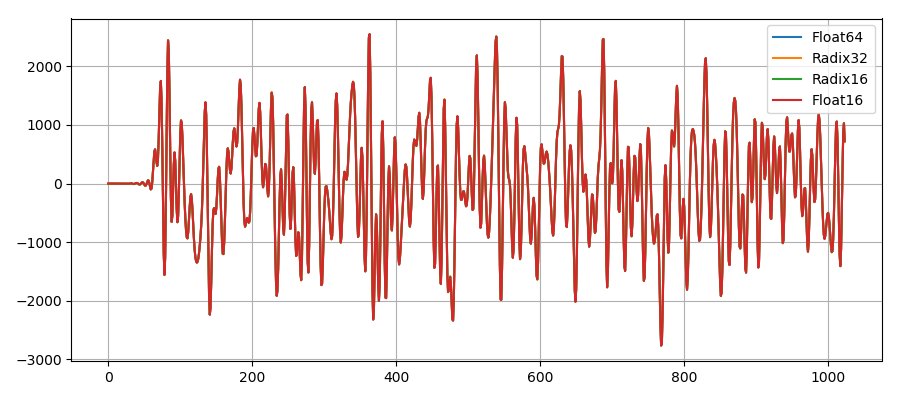

In [6]:
for key, val in results.items():
    plt.magnitude_spectrum(val, scale='dB', label=key)
show_plot()

for key, val in results.items():
    plt.plot(val, label=key)
show_plot()

<IPython.core.display.Javascript object>


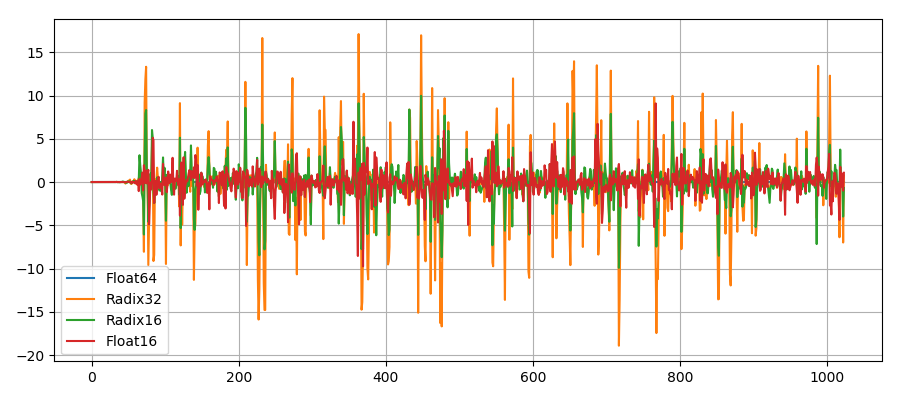

Float64 SNR: inf dB
Radix32 SNR: 51.717441226905265 dB
Radix16 SNR: 54.697674457665435 dB
Float16 SNR: 57.74060191405833 dB


/home/gaspar/git/pyha/pyha/common/util.py:109: RuntimeWarning: divide by zero encountered in double_scalars
  snr_db = 20 * np.log10(sig_pow / err_pow)


In [7]:
for key, val in results.items():
    plt.plot(results['Float64'] - val, label=key)
show_plot()

for key, val in results.items():
    print(f'{key} SNR: {snr(results["Float64"], val)} dB')
#     plt.plot(results['Float64'] - val, label=key)